<a href="https://colab.research.google.com/github/hmgene/salsa/blob/master/exonblox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Definition of Alternative Splicing Events  
Frequent splicing events are exon skipping (ES), mutually exclusive exons (ME), intron retention (IR), alternative donor (AD) and acceptor (AA) sites (PMID: 3304142). There is a general nomenclature to describe more complex events (PMID: 18688268). However, there are many problems with implementing defined events as computer programs. In this project we describe the splicing events with pseudo languages to be compiled into a programming language, python.

In this project, an **interval** is defined as an integer interval on a zero-base, half-open coordinate system. Using the interval we define exons linked by introns as a transcript on a chromosome. An exonic interval represents a contiguous fragment of a transcript. An intronic interval denotes splicing occuring between exons. 
We define some splicing events on a positive-stranded transcript (the events on a negative-strand is simply defined by swithcing 3 and 5 in their terminology.

**Alternative Acceptor (AA)** : two or more intronic intervals having the same donor or 5' site compose this event, represented by 
$ \{ (a,b) | \forall b > a \}  $

**Alternative Donor sites (AD)** : the same as A3 except the condition of the same acceptor or 3' site, represented by $\{ (a,b) | \forall a < b \} $

**Exon Skipping (ES)** : three intronic intervals with four sites, represented by $\{ (a,b),(a,d),(c,d) | b < c \} $

**Intron Retention (IR)**: one intronic interval overlapping with two unsplicing sites, represented by $\{ (a,b),(a-k,a+k),(b-k,b+k) |  b-a > k > 0 \} $  

## Data preparation
### Prepare a GTF file

1.   preprocess a GTF file: download data from ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_19/gencode.v19.annotation.gtf.gz and make an index (http://www.htslib.org/doc/tabix.html):
```
#!/bin/bash
i=gencode.v19.annotation.gtf.gz
o=gencode.v19.annotation.sorted.gtf.gz
(gunzip -dc $i | grep ^"#" ; gunzip -dc $i | grep -v ^"#" | sort -k1,1 -k4,4n) | bgzip > $o;
tabix -p gff $o;
#result files
#gencode.v19.annotation.sorted.gtf.#gz
#gencode.v19.annotation.sorted.gtf.gz.tbi
```

### Install some tools


In [ ]:
!pip install pysam
!pip install pybedtools
!apt-get install bedtools

Reading package lists... Done
Building dependency tree       
Reading state information... Done
bedtools is already the newest version (2.26.0+dfsg-5).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 59 not upgraded.


In [1]:
import pysam
import glob
import re
## put your target genes 
txt='''
VEGFA
IGFBP1
IGFBP3
THBS1
EDN1
PTK2
SF3B2
CSTF2
DDX46
U2SURP'''
TARGET_GENE={ i: 1 for i in filter(lambda x : x != "", txt.splitlines()) }

GTF="http://amc-sandbox.ucdenver.edu/User50/hmk/gencode.v19.annotation.gtf.gz"
try:
  pysam.TabixFile(GTF,'r').fetch( parser=pysam.asTuple())
except OSError:
  from google.colab import drive
  drive.mount('/content/drive')
  GTF="/content/drive/My Drive/proj/rebeccaSchweppe/gencode.v19.annotation.sorted.gtf.gz"
#data_files = glob.glob("/content/drive/My Drive/proj/rebeccaSchweppe/*.gz")

txt='''
SW1736_DasRes http://amc-sandbox.ucdenver.edu/User50/rebeccaSchweppe/hg19/SW1736_DasRes.bam
SW1736_Control http://amc-sandbox.ucdenver.edu/User50/rebeccaSchweppe/hg19/Sw1736_Control.bam
BCPAP_DasRes  http://amc-sandbox.ucdenver.edu/User50/rebeccaSchweppe/hg19/BCPAP_DasRes.bam
BCPAP_Control http://amc-sandbox.ucdenver.edu/User50/rebeccaSchweppe/hg19/BCPAP_Control.bam'''
fh=open("bam.tsv","w")
fh.write(txt)
fh.close()

GENE=dict();
for rec in pysam.TabixFile(GTF,'r').fetch( parser=pysam.asTuple()):
  if rec[2] == "exon":
    for g in re.findall("gene_name \"(\w+)\"",rec[8]):
      if g in TARGET_GENE:
        for tx in re.findall("transcript_id \"([\w\.]+)\"",rec[8]):
          chrom,gene,strand,start,end =(rec[0],g,rec[6], int(rec[3]),int(rec[4]))
          k=(chrom,gene,strand)
          GENE[k]=GENE.get(k,{})
          GENE[k][tx]=GENE[k].get(tx,[])
          GENE[k][tx].append((start,end))


def gene_boundary(genedata):
  for k in genedata:
    chrom,gene,strand=k
    x=[]
    for tx in genedata[k]:
      x=x+[ j for i in genedata[k][tx] for j in i]
    #cloc="%s:%d-%d" % (chrom,min(x),max(x));
    yield (k+(min(x),max(x)))
print("hi",GENE)
for i in gene_boundary(GENE):
  cloc="%s\t%s:%d-%d" % (i[1],i[0][3:len(i[0])],i[3],i[4])
  print(cloc)

#!cat bam.tsv

ModuleNotFoundError: ignored

In [ ]:
import pybedtools
pybedtools.set_bedtools_path(path="/usr/bin/")
from matplotlib import pyplot as plt

def count_intersect(a,b):
  a_str=""
  b_str=""
  for s in a : a_str += "c %s %s\n" % (s)
  for s in b: b_str += "c %s %s\n" % (s)
  a1=pybedtools.BedTool(a_str,from_string=True)
  b1=pybedtools.BedTool(b_str,from_string=True)
  for i in a1.intersect(b1,c=True):
    if(int(i[3])>0):
      yield (int(i[1]),int(i[2]),int(i[3]))

print( [ i for i in count_intersect([(1,3)],[(2,4)])] )

[(1, 3, 1)]


In [ ]:
import pysam
import sys
import numpy
import pybedtools

from matplotlib import pyplot as plt

def cigar_to_interval(cigarstr):
  rp=0 #reference pos
  qp=0 #query read pos
  res=[]
  for i in re.findall( "(\d+)([MDNIX=HSP])",cigarstr):
    l=int(i[0])
    if(re.match('[M=X]',i[1])):
      res.append((rp,rp+l))
      qp += l; rp += l
    elif(re.match('[DN]',i[1])):
      rp += l
    elif(re.match('[IS]',i[1])):
      qp += l
  return res    
#print(cigar_to_interval("10M340N91M"))

'''
  convert sam entry to list of intervals to represent
  both spliced [(a,b),(c,d)] and unspliced intervals [(a,b)] 
'''
def sam_to_interval(region):
  return [ (region.reference_start+i[0] - 1,
            region.reference_start+i[1] - 1)  
      for i in cigar_to_interval(region.cigarstring) ]

def density_interval(exon):
  z=dict()
  for y in exon:
    z[y[0]]=z.get(y[0],0) +1
    z[y[1]]=z.get(y[1],0) -1
  c=0;
  r=[]
  z1=sorted(z.keys())
  for i in range(len(z1)-1): 
    c=c+z[z1[i]];
    r.append((z1[i],z1[i+1],c))
  return r
#print(density_interval([(1,2),(4,5)]))

def plot_density(density,title,xlim):
  d=sorted(density,key=lambda x : x[0])
  d1=[d[0]]
  for i in range(1,len(d)):
    if d[i-1][1] != d[i][0]:
      d1.append( (d[i-1][1],d[i][0],0))
    d1.append(d[i])
  print(title)
  x=[ j for i in d1 for j in i[0:2] ]
  y=[ j for i in d1 for j in [i[2],i[2]] ]
  plt.figure(figsize=(20,2))
  ax=plt.axes();
  #fig, ax = plt.subplots(num=None, figsize=(20, 3), dpi=80, facecolor='w', edgecolor='k')
  ax.fill_between(x, y) 
  ax.set_xlim(xlim)
  #plt.title(title)
  plt.show()


def interval_to_junction(interval):
  r={}
  for x in interval:
    for i in range(1,len(x)):
      k=(x[i-1][1],x[i][0]) # junction
      r[k]=r.get(k,0)+1
  return r
#print(interval_to_junction([[(1,2),(4,5)]]))

def join_junctions(junctions):
  r={}
  for i in range(len(junctions)):
    for j in junctions[i]:
      r[j]=r.get(j,[0,]*len(junctions))
      r[j][i] += junctions[i][j]
  return r

def _psi_filter(m,mins,mind):
    ok=False
    f=numpy.array(m,dtype='f')
    if( m.sum() >= mins ):
        for i in range(f.ndim):
          f[i,]=[j/(sum(f[i,:])) for j in f[i,:]] # row frequency
        for j in range(f.transpose().ndim):
          d=(max(f[:,j])-min(f[:,j]))
          if d >= mind: ok=True 
        if(ok): yield f 

def a35(junctions,mins,mind,strand):
  r={}
  for i in junctions:
    r[i[0]]=r.get(i[0],{})
    r[i[0]][i[1]]=junctions[i]
    r[i[1]]=r.get(i[1],{})
    r[i[1]][i[0]]=junctions[i]
  for a in r:
    k=[ b for b in filter(lambda x: x> a, r[a]) ]
    if len(k) > 1: 
      m=numpy.array( [ r[a][b] for b in k] ).transpose()
      for f in _psi_filter(m,mins,mind):
        ty="A3"
        if strand == "-" : ty="A5"
        yield (ty,[(a,b) for b in k],m,f)
      
    k=[ b for b in filter(lambda x: x< a, r[a]) ]
    if len(k) > 1: 
      m=numpy.array( [ r[a][b] for b in k] ).transpose()
      for f in _psi_filter(m,mins,mind):
        ty="A5"
        if strand == "-" : ty="A3"
        yield (ty,[(b,a) for b in k],m,f)

  

def count_unsp(x,y):
  r={}
  for i in count_intersect([ (i,i+1) for i in x],intv):
    if(i[2] > 0):
      r[i[0]]=r.get(i[0],0) + 1
  return(r)
count_unsp([1,2,3],[(2,3)])

#{2: 1}

#j1=interval_to_junction([[(1,2),(4,5)],[(1,2),(5,6)],[(1,2),(10,11)], [(1,2),(4,5)],[(1,2),(5,6)]])
#j2=interval_to_junction([[(1,2),(4,5)]])
#jj=join_junctions([j1,j2])
jj={(134094644, 134099592): [133, 262], (134099781, 134102605): [144, 218], (134102749, 134106591): [140, 226], (134106688, 134109384): [192, 188], (134106688, 134109396): [1, 0], (134109550, 134113262): [121, 197], (134113313, 134116821): [3, 7], (134113414, 134116821): [123, 162], (134113414, 134116824): [15, 0], (134116866, 134116866): [7, 0], (134116935, 134117609): [155, 274], (134117775, 134118633): [172, 259], (134117775, 134120054): [1, 4], (134118754, 134120054): [190, 281], (134118679, 134118680): [1, 0], (134118754, 134121153): [1, 5], (134120230, 134121153): [137, 245], (134120487, 134121153): [2, 2], (134121275, 134124201): [159, 224], (134124280, 134126158): [162, 201], (134124280, 134124904): [3, 8], (134124280, 134125794): [3, 13], (134124280, 134124900): [1, 2], (134124953, 134125794): [5, 5], (134126241, 134130538): [184, 262], (134125911, 134126158): [7, 21], (134130703, 134131676): [169, 261], (134131839, 134143436): [159, 261], (134143630, 134146909): [162, 258], (134146984, 134146985): [1, 0], (134147047, 134147384): [195, 288], (134147534, 134152118): [159, 233], (134152292, 134153184): [60, 73], (134153403, 134154548): [173, 270], (134154693, 134162635): [210, 380], (134154693, 134164347): [1, 3], (134162709, 134164347): [175, 356], (134164403, 134164403): [1, 1], (134164435, 134169269): [1, 0], (134164435, 134190586): [2, 0], (134164506, 134164507): [2, 0], (134164552, 134190586): [4, 8], (134181901, 134190586): [55, 133], (134190851, 134193045): [1, 1], (134102749, 134109384): [0, 1], (134109475, 134109477): [0, 1], (134116935, 134118633): [0, 1], (134121226, 134121227): [0, 1], (134124953, 134126158): [0, 5], (134124657, 134124658): [0, 1], (134125276, 134125276): [0, 7], (134143630, 134146934): [0, 3], (134147462, 134147463): [0, 2], (134164506, 134164506): [0, 3], (134169312, 134190586): [0, 3], (134181426, 134190586): [0, 1], (134182552, 134190586): [0, 10]}

for x in a35(jj,10,0.1,"+"):
  print(x)

TypeError: ignored

In [ ]:
bamurls=['http://amc-sandbox.ucdenver.edu/User50/rebeccaSchweppe/hg19/SW1736_DasRes.bam',
'http://amc-sandbox.ucdenver.edu/User50/rebeccaSchweppe/hg19/Sw1736_Control.bam']

bamdb1= pysam.AlignmentFile(bamurls[0]);
bamdb2= pysam.AlignmentFile(bamurls[1]);
for k in GENE:
  chrom=k[0][3:]
  x=[ p for tx in GENE[k] for ex in GENE[k][tx] for p in ex]
  xlim=(min(x),max(x))
  i1= [ sam_to_interval(region) for region in bamdb1.fetch(chrom,xlim[0],xlim[1]) ]
  j1=interval_to_junction(i1)
  i2= [ sam_to_interval(region) for region in bamdb2.fetch(chrom,xlim[0],xlim[1]) ]
  j2=interval_to_junction(i2)
  #print(join_junctions([j1,j2]))
  jj=join_junctions([j1,j2])

  for ev in a35(jj,10,0.1,k[2]):
    print(k,ev)
  #jn=[ (i,i+1) for i in set([ j for i in ev[1] for j in i])]
  #print(jn[2])
  u1=[ i[0] for i in filter(lambda x: len(x)==1,i1)]

  #plot_density(density_interval([ j for i in i1 for j in i]),k,xlim)
  #plot_density(density_interval([ j for i in i2 for j in i]),k,xlim)
 
  #plot_gene(ganno,k)
  #for i in introns:
   # if i[0] in ganno[k] and i[1]+1 in ganno[k]:
    #  print(i)

('chr5', 'DDX46', '+') ('A3', [(134113414, 134116821), (134113414, 134116824)], array([[123,  15],
       [162,   0]]), array([[0.8913044 , 0.10869565],
       [1.        , 0.        ]], dtype=float32))
('chr5', 'DDX46', '+') ('A5', [(134124280, 134125794), (134124953, 134125794)], array([[ 3,  5],
       [13,  5]]), array([[0.375    , 0.625    ],
       [0.7222222, 0.2777778]], dtype=float32))
('chr5', 'DDX46', '+') ('A3', [(134124953, 134125794), (134124953, 134126158)], array([[5, 0],
       [5, 5]]), array([[1. , 0. ],
       [0.5, 0.5]], dtype=float32))
('chr8', 'PTK2', '-') ('A3', [(141900867, 142011222), (141958821, 142011222), (141935847, 142011222), (141994253, 142011222)], array([[32, 10, 31,  7],
       [33,  0, 31, 10]]), array([[0.4       , 0.125     , 0.3875    , 0.0875    ],
       [0.44594595, 0.        , 0.4189189 , 0.13513513]], dtype=float32))
('chr8', 'PTK2', '-') ('A3', [(141900867, 141958763), (141935847, 141958763)], array([[ 6, 10],
       [ 0,  2]]), array([[0.

## RNA-seq Simulator
A simple simulator generates RNA-seq reads that can be used in our pipelines. We define a transcript loction in a genome using a set of exonic intervals. Multiple RNA
 isoforms defined in a genome determin alternative splicing forms and events. 

In [ ]:
t1=[(100,200),(300,400),(500,600)]
t2=[(100,200),(300,400),(500,600)]

j=[ { "a": 1 , "b" :2 }, {"c":3} ]
x=[ i[k] for i in j for k in i ]
print(x)

[1, 2, 3]


## Splicing Events
alternative 3' choice : 




In [ ]:
#!pip install ncls
from ncls import NCLS
import pandas as pd
import numpy as np

starts = pd.Series(range(0, 5))
ends = starts + 100
ids = starts

subject_df = pd.DataFrame({"Start": starts, "End": ends}, index=ids)

print(subject_df)
#    Start  End
# 0      0  100
# 1      1  101
# 2      2  102
# 3      3  103
# 4      4  104
x=np.array([1,2,3], dtype=np.int64)
ncls = NCLS(x,x+1,x)

#ncls = NCLS(starts.values, ends.values, ids.values)

# python API, slower
it = ncls.find_overlap(1, 3)
for i in it:
    print(i)


ModuleNotFoundError: ignored

In [ ]:
## parameters of simulation
T1=[(100,200),(500,600)] 
T2=[(100,200),(300,400),(500,600)]
N1=100
N2=200
READLEN=50

'''
 convert transcriptional positions to genomic positions
'''
def tx2gx(interval,annotation): # t is transcript
  (s,e)=interval
  x=0 ## transcript pos
  r=[]
  for i in range(len(annotation)):
    es=annotation[i][0] # exon start
    ee=annotation[i][1] # exon end
    l=ee-es # exon len
    if s < x + l and e > x: # overlapping
      r.append((max(x,s)+es-x,min(x+l,e)+es-x)) ## [es  s ee]-----[es e   ee]
    x=x+l
  return r
#print(tx2gx((50,250),T1))

from numpy import random

'''
generate list of list of intervals
'''
def gen_alignment(transcript, readlen, readnum):
  l=0
  for i in transcript:
    l=l+i[1]-i[0]
  return [ tx2gx( (i,i+readlen),transcript)  \
          for i in sorted(random.randint( \
              l-readlen+1,
              size=(readnum)))]
#print( gen_alignment(T1,50,100) )

from numpy import random
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import sys
import pysam
import pybedtools
import re

print(anno)


''' definitions
 interval : (start,end)
 count interval  : (start,end,count)
 splicing count interval : [ count interval ]

'''

## parse transcript
def parset(t):
  l=0
  exon=[]
  for x in t.split("^"):
    e=list(map(int, x.split("-")))
    l = l + e[1]-e[0]
    exon.append(e)
  sorted(exon,key=lambda x : x[0] )
  return(l,exon)

'''
  convert a continuous transcript interval 
  to its genomic (spliced) interval
'''


'''
generate spliced alignments 
'''




def count_interval(alignment):
  z=dict()
  for y in [ j for i in alignment for j in i]:
    z[y[0]]=z.get(y[0],0) +1
    z[y[1]]=z.get(y[1],0) -1
  c=0;
  r=[]
  z1=sorted(z.keys())
  for i in range(len(z1)-1): 
    c=c+z[z1[i]];
    r.append((z1[i],z1[i+1],c))
  return r
def plot1(intervalcount):
  x=[ j for i in intervalcount for j in i[0:2] ]
  y=[ j for i in intervalcount for j in [i[2],i[2]] ]
  plt.fill_between(x, y)
  plt.show()

def count_junction(alignment):
  r=dict()
  for a in alignment:
    for i in range(len(a)-1):
      j=(a[i][1],a[i+1][0])
      r[j]=r.get(j,0) + 1 
  return r

#TPM=rpb/sum_rpb * 10^6
alignment1=gen_alignment(T1,READLEN,N1)
alignment2=gen_alignment(T2,READLEN,N2)
intervalcount=count_interval(alignment1+alignment2)
plot1(intervalcount)
jcount=count_junction(alignment1+alignment2)


#df=pd.DataFrame({'x': x, 'y' : y} )
#plt.plot('x','y',data=df)
#plt.show()

#y=[1,1,2,2,3,3]
#x=[1,4,4,5,6,6]

  
'''
url='http://amc-sandbox.ucdenver.edu/User50/632-KDM5A.bam'
d= pysam.AlignmentFile(url);
for ref in d.references:
  intron=d.find_introns( region for region in d.fetch(ref) )
  print(ref,len(intron))
'''

#  print(region)
 # print(region.find_introns())
 # print(sam_to_interval(region))
#  print(d.find_introns((region)))
  #coordinates,up_to_intron_dist = getSpliceSites(entry.cigar,X)



[[(102, 152)], [(102, 152)], [(103, 153)], [(104, 154)], [(108, 158)], [(109, 159)], [(113, 163)], [(114, 164)], [(114, 164)], [(122, 172)], [(122, 172)], [(123, 173)], [(127, 177)], [(127, 177)], [(129, 179)], [(131, 181)], [(133, 183)], [(135, 185)], [(136, 186)], [(137, 187)], [(139, 189)], [(141, 191)], [(144, 194)], [(148, 198)], [(149, 199)], [(152, 200), (500, 502)], [(153, 200), (500, 503)], [(153, 200), (500, 503)], [(153, 200), (500, 503)], [(155, 200), (500, 505)], [(157, 200), (500, 507)], [(157, 200), (500, 507)], [(158, 200), (500, 508)], [(159, 200), (500, 509)], [(162, 200), (500, 512)], [(164, 200), (500, 514)], [(170, 200), (500, 520)], [(170, 200), (500, 520)], [(171, 200), (500, 521)], [(171, 200), (500, 521)], [(171, 200), (500, 521)], [(172, 200), (500, 522)], [(172, 200), (500, 522)], [(173, 200), (500, 523)], [(173, 200), (500, 523)], [(178, 200), (500, 528)], [(180, 200), (500, 530)], [(182, 200), (500, 532)], [(186, 200), (500, 536)], [(186, 200), (500, 536)],

ModuleNotFoundError: ignored

## Extract gene annotations of target genes

In [ ]:
%%bash
samtools
#import subprocess
#r=subprocess.run([ "python", "sashimi-plot.py -b bam.tsv -g ",GTF," -c 11:65819816-65836382"])
#print(r)
#%%bash
#echo $gtf
#python sashimi-plot.py -b "bam.tsv" -g $gtf -c 11:65819816-65836382 
#-C 2 --base-size=20 --ann-height=4 --height=3 --width=18


bash: line 1: samtools: command not found


In [ ]:
import glob
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
import matplotlib.pyplot as plt 
def plot_gene(ganno,k):
  plt.figure(figsize=(20,ganno[k]["tx.size"]*0.2))
  ax=plt.axes()
  ax.set_title(k)
  plt.yticks([])
  #ax.set_ylim(0,10*len(ganno[k].keys()))
  i=0
  for t in ganno[k]["tx"]:
    x=[ (i[0],i[1]-i[0]) for i in ganno[k]["tx"][t].keys() ]
    ax.broken_barh(x, (10*i,5),facecolors='tab:blue')
    i += 1
  plt.show()
for k in GENE:
  gene_plot(GENE,k)
  plt.show()

  #if k!=('chr7','IGFBP1','+') : continue 
  #if k!= ('chr3','U2SURP','+') : continue #('chr11','SF3B2','+') : continue 


#ax1.broken_barh([(110, 30), (150, 10)], (10, 10), facecolors='tab:blue')
#ax.broken_barh([(10, 50), (100, 20), (130, 10)], (15, 10),
 #              facecolors=('tab:orange', 'tab:green', 'tab:red'))
#ax.set_ylim(5, 35)
#ax.set_xlim(0, 200)
#ax.set_xlabel('seconds since start')
#ax.set_yticks([15, 25])
#ax.set_yticklabels(['Bill', 'Jim'])
#ax.grid(True)
#ax.annotate('race interrupted', (61, 25),
 #           xytext=(0.8, 0.9), textcoords='axes fraction',
  #          arrowprops=dict(facecolor='black', shrink=0.05),
   #         fontsize=16,
    #        horizontalalignment='right', verticalalignment='top')



NameError: ignored

## Define some functions

# Simulate RNA-seq


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  if __name__ == '__main__':


NameError: ignored

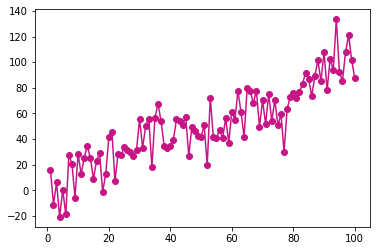

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
 
# Create data
df=pd.DataFrame({'x': range(1,101), 'y': np.random.randn(100)*15+range(1,101), 'z': (np.random.randn(100)*15+range(1,101))*2 })
df 
# plot with matplotlib
plt.plot( 'x', 'y', data=df, marker='o', color='mediumvioletred')
plot.show()


# New Section

In [ ]:
a=[1,2,3]
print(a[0:2])

[1, 2]


# New Section

# Useful Links
https://github.com/flemingtonlab/SpliceV/blob/master/bin/SpliceV
